In [149]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchinfo
from keras.src.backend import shape
from torch import nn
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from PIL import Image
import kagglehub


2025-12-06 12:53:33.547791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [151]:
path = kagglehub.dataset_download("prasunroy/natural-images")
print("Path to dataset files:", path)


Path to dataset files: /Users/andreakorunoska/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1


#### Configurtations

In [152]:
CONFIGURATION = {
    'width': 320,
    'height': 240,
    'patch_w_h': 64,
    'max_shift': 16,
    'image_size': (320, 240),
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 30000,
}


 ## Generate samples

In [153]:
class HomographyDataset(Dataset):
    def __init__(self, image_paths, img_size=(320,320), patch_size=64, max_shift=16, samples_per_image=50, batch_size=1):
        self.image_paths = image_paths
        self.img_size = img_size
        self.patch_size = patch_size
        self.max_shift = max_shift
        self.samples_per_image = samples_per_image

        self.index = []
        for p in image_paths:
            for _ in range(samples_per_image):
                self.index.append(p)
        random.shuffle(self.index)

        self.transform = transforms.Compose([
            transforms.Resize((img_size[1], img_size[0])),
            transforms.CenterCrop((img_size[1], img_size[0])),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

        self.loader = DataLoader(self, batch_size=batch_size, shuffle=True)

    def __len__(self):
        return len(self.index)

    def load_and_preprocess(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image.squeeze(0).numpy() ## todo why i neewd squeeze

    def pick_random_patch(self, image_w, image_h):
        safety = self.max_shift + 20
        x = np.random.randint(safety, image_w - self.patch_size - safety)
        y = np.random.randint(safety, image_h - self.patch_size - safety)
        return x, y

    def window_corners(self, x, y):
        return np.array([
            [y,     x],
            [y, x + self.patch_size - 1],
            [y + self.patch_size - 1, x + self.patch_size - 1],
            [y + self.patch_size - 1, x]
        ], dtype=np.float32)

    def random_offsets(self):
        return np.random.randint(-self.max_shift, self.max_shift + 1, size=(4,2)).astype(np.float32)

    def generate_sample(self, image):
        image_H, image_W = image.shape

        x,y = self.pick_random_patch(image_W, image_H) # picking valid window

        base = self.window_corners(x, y)
        offsets = self.random_offsets()
        moved = base + offsets ## base and perturbed corners

        # Homography
        H_mat = cv2.getPerspectiveTransform(base, moved) ## todo why do i need this function
        H_mat_inv = np.linalg.inv(H_mat) ## todo  wy do i need this

        # Wrapping the whole image
        wrapped_image = cv2.warpPerspective(image, H_mat_inv, (image_W, image_H))

        # Crop patches
        patch =  image[y:y+self.patch_size, x:x+self.patch_size]# what is thhis todo
        warped_image = wrapped_image[y:y+self.patch_size, x:x+self.patch_size] # todo why do we need this

        # stack patch for 2 channel input
        two_channel = np.stack([patch, warped_image], axis=0) # todo why do i need axs 0

        return {
            "sample": torch.FloatTensor(two_channel),
            "offsets": torch.FloatTensor(offsets),
            "base_corners": torch.FloatTensor(base),
            "moved_corners": torch.FloatTensor(moved),
            "H_mat": torch.FloatTensor(H_mat),
            "image": image,  # Add original image for visualization
            "warped_image": warped_image,  # Add warped image for visualization
        }

    def __getitem__(self, idx):
        image_path = self.index[idx]
        image_np = self.load_and_preprocess(image_path) # todo what is np
        data = self.generate_sample(image_np)

        return (
            data['offsets'],  # augment_tensor
            data['base_corners'],  # corners_tensor
            data['moved_corners'],  # aug_corners_tensor
            data['H_mat'],  # H_mat_tensor
            torch.FloatTensor(image_np).unsqueeze(0),  # img_tensor (1, H, W)
            torch.FloatTensor(data['warped_image']).unsqueeze(0),  # warped_full_tensor (1, H, W)
            data['sample'][0:1],  # patch_tensor (1, patch_size, patch_size) - take first channel
            data['sample'][1:2],  # warped_tensor (1, patch_size, patch_size) - take second channel
        )


In [154]:
def create_dataset(data_dir, batch_size=16, img_size=(320, 320), patch_size=64, max_shift=16):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
    image_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images")

    dataset = HomographyDataset(
        image_paths=image_paths,
        img_size=img_size,
        patch_size=patch_size,
        max_shift=max_shift,
        samples_per_image=50,
        batch_size=batch_size
    )

    return dataset


Found 13798 images


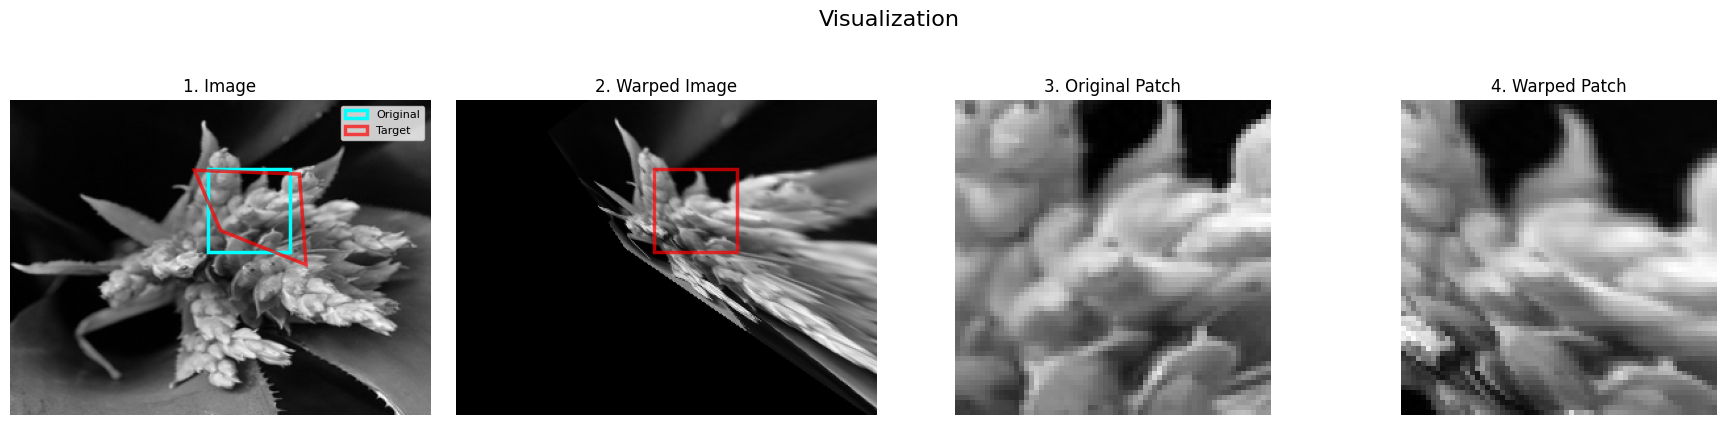

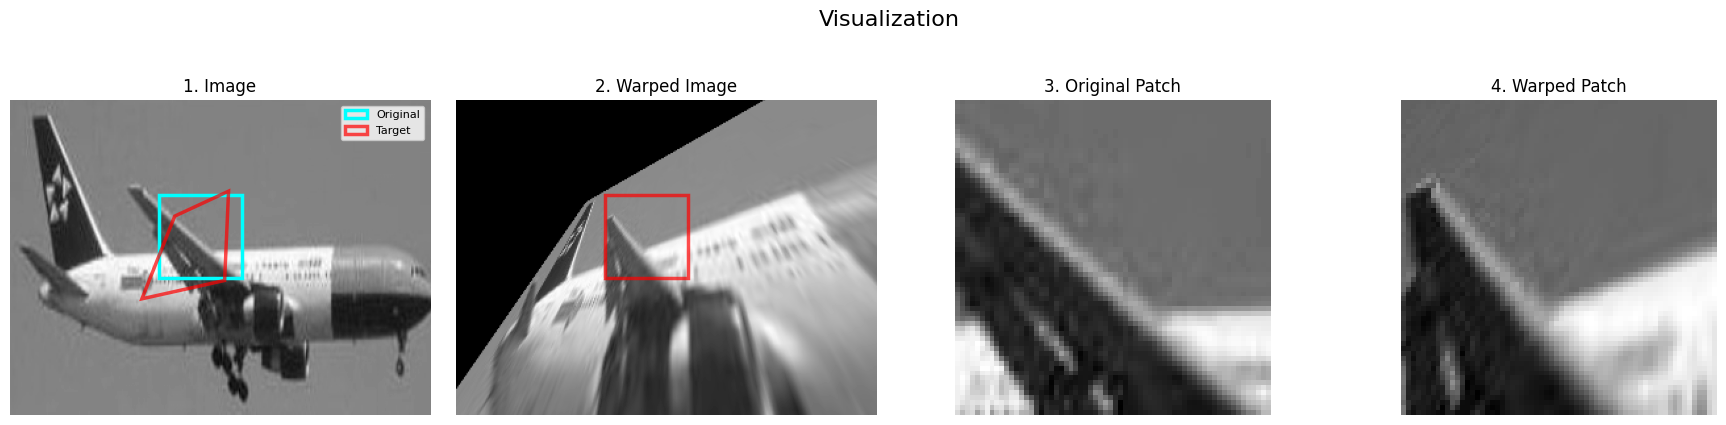

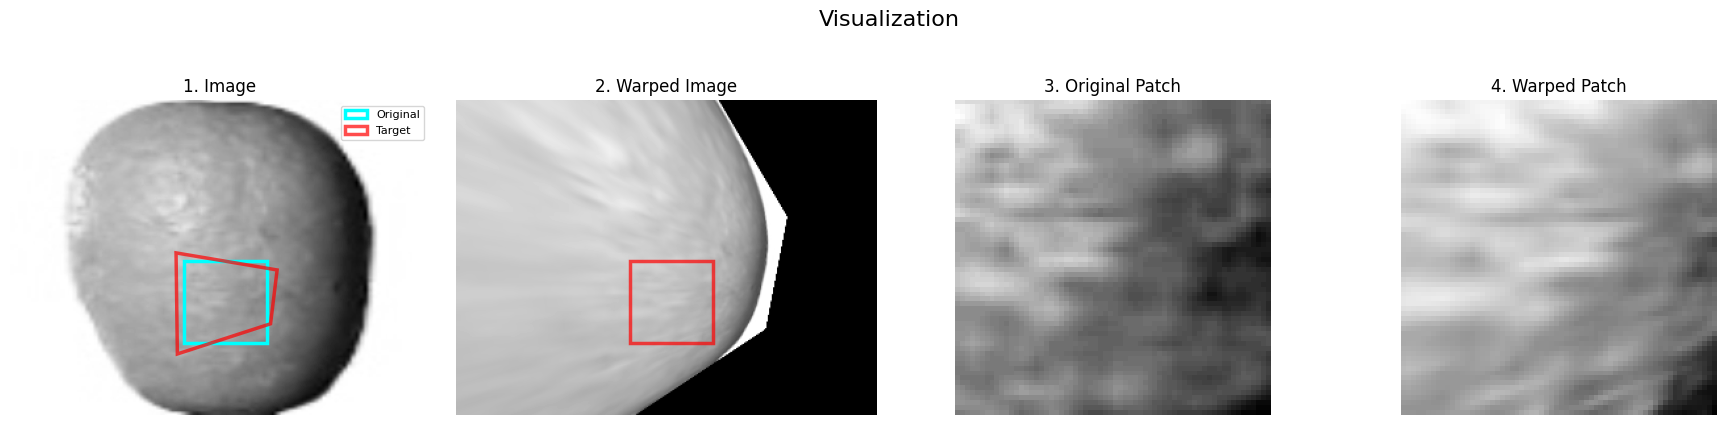

In [155]:
dataset = create_dataset(
    data_dir=path,
    img_size=(CONFIGURATION['width'], CONFIGURATION['height']),
    patch_size=CONFIGURATION['patch_w_h'],
    max_shift=CONFIGURATION['max_shift'],
    batch_size=CONFIGURATION['batch_size']
)

for n in range(3):
    offsets, pts, pts_aug, H_mat, img, img_warp, patch, patch_warp = next(iter(dataset.loader))

    img_np = (img[0].numpy().transpose(1, 2, 0).squeeze() * 0.5 + 0.5)
    corners_orig_xy = pts[0].numpy()[:, ::-1]
    corners_warped_xy = pts_aug[0].numpy()[:, ::-1]

    H_forward = cv2.getPerspectiveTransform(corners_orig_xy.astype(np.float32),
                                           corners_warped_xy.astype(np.float32))
    height, width = img_np.shape
    img_warped_full = cv2.warpPerspective(img_np, H_forward, (width, height))

    x, y = int(corners_orig_xy[0, 0]), int(corners_orig_xy[0, 1])
    patch_size = CONFIGURATION['patch_w_h']
    patch_original = img_np[y:y+patch_size, x:x+patch_size]
    patch_warped_from_full = img_warped_full[y:y+patch_size, x:x+patch_size]

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    axs[0].imshow(img_np, cmap="gray")
    axs[0].add_patch(plt.Polygon(corners_orig_xy, fill=False, ec="cyan", lw=2.5, label="Original"))
    axs[0].add_patch(plt.Polygon(corners_warped_xy, fill=False, ec="red", lw=2.5, label="Target", alpha=0.7))
    axs[0].set_title("1. Image", fontsize=12)
    axs[0].set_axis_off()
    axs[0].legend(loc='upper right', fontsize=8)

    axs[1].imshow(img_warped_full, cmap="gray")
    axs[1].add_patch(plt.Polygon(corners_orig_xy, fill=False, ec="red", lw=2.5, alpha=0.7))
    axs[1].set_title("2. Warped Image", fontsize=12)
    axs[1].set_axis_off()

    axs[2].imshow(patch_original, cmap="gray")
    axs[2].set_title(f"3. Original Patch", fontsize=12)
    axs[2].set_axis_off()

    axs[3].imshow(patch_warped_from_full, cmap="gray")
    axs[3].set_title(f"4. Warped Patch", fontsize=12, )
    axs[3].set_axis_off()

    plt.suptitle(f'Visualization', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

### Neural network

In [156]:
class ResNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.convolution1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.normalization1 = nn.BatchNorm2d(output_channels)
        self.convolution2 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.normalization2 = nn.BatchNorm2d(output_channels)

        if input_channels != output_channels:
            self.identity = nn.Conv2d(input_channels, output_channels, kernel_size=1, padding='same', stride=1)
        else:
            self.identity = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.identity(x)
        out = self.convolution1(x)
        out = self.normalization1(out)
        out = self.relu(out)
        out = self.convolution2(out)
        out = self.normalization2(out)
        out += identity
        out = self.relu(out)

        return out

### todo do i need to implement with downsample or is this oaky

In [161]:
class HomographyBody(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        # First conv takes 2 channels (original patch + warped patch)
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.stage1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            nn.MaxPool2d(2)   # 64 → 32
        )

        self.stage2 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            nn.MaxPool2d(2)   # 32 → 16
        )

        # FIX: correct name
        self.conv_up = nn.Conv2d(64, 128, kernel_size=1, bias=False)

        self.stage3 = nn.Sequential(
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
            nn.MaxPool2d(2)   # 16 → 8
        )

        self.stage4 = nn.Sequential(
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
        )

        # 8x8 spatial map with 128 channels → 8192-unit vector
        feat_map = CONFIGURATION['patch_w_h'] // 8   # 64/8 = 8
        feat_dim = 128 * feat_map * feat_map

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True)
        )
## todo how are we handling hte calculations
    def forward(self, x):
        out = self.initial(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.conv_up(out)    # FIXED LINE
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.fc(out)
        return out


#### Regression

In [165]:
class RegressionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=8):
        super().__init__()
        self.regression = nn.Sequential(
            HomographyBody(in_dim),
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x: torch.Tensor): ## todo wy x is torch tensor
        x = self.regression(x)
        return x

In [166]:
regression = RegressionHead().to(device)
regression_optimizer = torch.optim.Adam(regression.parameters(), lr=CONFIGURATION['learning_rate'])
regression_loss = nn.MSELoss()

torchinfo.summary(
    regression,
    [1,2,64,64],
    depth=4
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

#### Classification

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=168):
        super().__init__()
        self.classification = nn.Sequential(
            HomographyBody(in_dim),
            nn.Linear(in_dim, out_dim),
        )
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x: torch.Tensor):
        x = self.classfication(x)
        x = x.view(-1, 21, 8) # [B, 168] -> [B, 21, 8]
        x = self.softmax(x)
        return x

In [ ]:
classification = ClassificationHead().to(device)
classification_optimizer = torch.optim.Adam(regression.parameters(), lr=CONFIGURATION['learning_rate'])
classification_loss = nn.MSELoss()

torchinfo.summary(
    classification,
    [1,2,64,64],
    depth=4
)

### Train model


In [148]:
def train_model(model, model_optimizer, model_loss, model_name):
    model_train_loss =[]
    for epoch in range(CONFIGURATION['epochs']):
        model.train()
        training_loss = 0.0

        for offsets, pts, pts_aug, H_mat, img, img_warp, patch, patch_warp in dataset.loader:
            input = torch.cat([patch, patch_warp], dim=1).to(device)
            target = offsets.view(-1, 8).to(device)
            model_optimizer.zero_grad()
            output = model(input)
            loss = model_loss(output, target)
            loss.backward()
            model_optimizer.step()

            training_loss += loss.item() ## is the same if i use input.shape[0] i shoudl add this if i use other batch size

        model_train_loss.append(training_loss/len(dataset.loader.dataset))

        epoch_loss = training_loss / len(dataset.loader.dataset)
        print(f"Epoch: {epoch+1}/{CONFIGURATION['epochs']}, Train Loss: {epoch_loss:.6f}")

    torch.save(model, f"models/{model_name}.pt")

SyntaxError: invalid syntax (2975474496.py, line 19)

In [ ]:
train_model(regression, regression_optimizer, regression_loss, "regression")

In [ ]:
train_model(classification, classification_optimizer, classification_loss, "classification")

### Visualize loss and prediction

In [ ]:
def plot_loss(loss_list, window):
    loss = np.array(loss_list, dtype=float)

    if len(loss) >= window:
        shape = (loss.size - window + 1, window)
        strides = (loss.strides[0], loss.strides[0])
        windows = np.lib.stride_tricks.as_strided(loss, shape=shape, strides=strides)
        smooth = windows.mean(axis=1)
    else:
        smooth = loss

    plt.figure(figsize=(8,4))
    plt.plot(loss, label="Raw loss")
    plt.plot(range(window-1, window-1 + len(smooth)), smooth, label=f"Smoothed (window={window})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_loss(regression_loss, 10)

In [ ]:
plot_loss(classification_loss, 10)

In [ ]:
def visualize_homography_prediction(dataset, model, device, patch_size):
    model.eval()

    offsets, pts, pts_aug, H_mat, img, img_warp, patch, patch_warp = next(iter(dataset.loader))

    img_np = (img[0].numpy().transpose(1, 2, 0) * 0.5 + 0.5).squeeze()
    original_xy = pts[0].numpy()[:, ::-1]         # (y,x) → (x,y)
    target_xy   = pts_aug[0].numpy()[:, ::-1]

    with torch.no_grad():
        inp = torch.cat([patch, patch_warp], dim=1).to(device)
        pred_offsets = model(inp).cpu()                  # (B, 8)
        pred_xy = (pts.view(-1, 8)[0] + pred_offsets[0]) # add offsets
        pred_xy = pred_xy.view(4, 2).numpy()[:, ::-1]    # reshape + swap

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img_np, cmap="gray")

    ax.add_patch(plt.Polygon(original_xy, fill=False, ec="cyan", lw=2.5, label="Original patch"))
    ax.add_patch(plt.Polygon(target_xy, fill=False, ec="red", lw=2.5, label="Target patch"))
    ax.add_patch(plt.Polygon(pred_xy, fill=False, ec="yellow", lw=2.5, label="Predicted patch"))

    ax.set_axis_off()
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_homography_prediction(dataset, regression, device, CONFIGURATION['patch_size'])


In [ ]:
visualize_homography_prediction(dataset, classification, device, CONFIGURATION['patch_size'])
